In [1]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [1034]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, insert_zero_params, rescale_manybody_params
from statmechlib.preprocessing import Trajectory, find_index, pair_dist_cutoff, universal_eos
from statmechlib.forcefields import utot_EAM_per_atom, utot_EAM_per_box, udif_print, u_core

In [986]:
target_proc = '../data/target_processed'
working = '../data/working'
reports = '../reports'
pot_path = '../sim/potentials'

In [269]:
params_file = 'marinica_params'
stats_file = 'stats_marinica'
target_file = 'target_marinica'
stats_file = 'stats_manyknots' # 'stats_samples'
target_file = 'target_manyknots' # 'target_samples'
params_file = 'marinica_params'
stats_file = 'stats_manymd' # 'stats_samples'
target_file = 'target_manymd' # 'target_samples'
#stats_file = 'stats_manyvac' # 'stats_samples'
#target_file = 'target_manyvac' # 'target_samples'

stats_file = 'stats_test' # 'stats_samples'
target_file = 'target_test' # 'target_samples'
stats_file = 'stats_manyall' # 'stats_samples'
target_file = 'target_manyall' # 'target_samples'
# stats_file = 'stats_everyzero' # 'stats_samples'
# target_file = 'target_everyzero' # 'target_samples'
# stats_file = 'stats_manyknots' # 'stats_samples'
# target_file = 'target_manyknots' # 'target_samples'
stats_md_file = 'stats_onlymd' # 'stats_samples'
target_md_file = 'target_onlymd' # 'stats_samples'
#stats_file = 'stats_everything' # 'stats_samples'
#target_file = 'target_everything' # 'target_samples'

In [1222]:
with open(os.path.join(working, stats_md_file+'.pickle'), 'rb') as fi:
    stats_md = pickle.load(fi)
    
with open(os.path.join(working, target_md_file+'.pickle'), 'rb') as fi:
    targets_md = pickle.load(fi)

with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_all = pickle.load(fi)

with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)  

In [1223]:
# # extended knots
# pair_knots = [ 2.45, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375, 5.78]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9, 5.5]

# pair_knots = [ 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

# pair_knots = [ 2.3, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

# pair_knots = [2.26, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

# pair_knots = [2.26, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

In [1224]:
def downselect(stats_inp, pair_knots, edens_knots):
    
    # find idices of knots
    pair_index = find_index(pair_knots, stats_inp['hyperparams']['pair'])
    edens_index = find_index(edens_knots, stats_inp['hyperparams']['edens'])
    
    # create boolean arrays with select indices set to True
    p_ix = np.array([True if i in pair_index else False for i in range(len(stats_inp['hyperparams']['pair']))])
    m_ix = np.array([True if i in edens_index else False for i in range(len(stats_inp['hyperparams']['edens']))])

    stats_out = select_nodes(stats_inp, p_ix, m_ix)
    
    return stats_out

In [1301]:
pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
        3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
        4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
edens_knots = [ 2.5, 2.8663175, 3.1,  3.5,  4.5, 4.9, 5.4604375]

In [1302]:
stats = downselect(stats_all, pair_knots, edens_knots)
print(stats['hyperparams'])
stats_select_md = downselect(stats_md, pair_knots, edens_knots)
print(stats_select_md['hyperparams'])

{u'pair': [2.2200000000000002, 2.46, 2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.4016950000000001, 5.4604375000000003], u'edens': [2.5, 2.8663175000000001, 3.1000000000000001, 3.5, 4.5, 4.9000000000000004, 5.4604375000000003]}
{u'pair': [2.2200000000000002, 2.46, 2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.4016950000000001, 5.4604375000000003], u'edens': [2.5, 2.8663175000000001, 3.1000000000000001, 3.5, 4.5, 4.9000000000000004, 5.4604375000000003]}


In [1303]:
targets['md'] = targets_md['md']
stats['md'] = stats_select_md['md']

In [1304]:
for key in sorted(targets.keys()):
    #if 'bcc_npt' not in key:
    #    continue
    for box, xyz, ene in zip(targets[key]['box'], targets[key]['xyz'], stats[key]['energy']):
        #print(np.linalg.det(box), len(xyz), len(ene), type(ene))
        n = len(xyz)
        vol = np.linalg.det(box)
        corr = float(n*n)/vol
        #print(n, corr)
        ene.append([corr])

In [1305]:
# optimal_params = []
# for params in param_list:
#     eam_params = list(params['params']['embed']) + list(params['params']['pair']) + list(params['params']['edens'])
#     #eam_params = list(params['params']['embed']) + [0.0] + list(params['params']['pair']) + [0.0] + list(params['params']['edens']) + [0.0]
#     optimal_params.append((0.0, np.array(eam_params)))

In [1414]:
# # The three potentials below were produced with these knots
# # pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
# #         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
# #         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# # edens_knots = [ 2.5, 2.8663175, 3.1,  3.5,  4.9, 5.4604375]

# Marinica
optimal_params = [(0.0, np.array([ -5.94645400e+00,  -4.94770000e-02,  0.0, 0.0, 9.60851701e+01,
          -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
           7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
           1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
           1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
          -1.63131143e+00,   1.38409896e+00,  -4.20429108e+00, 0.0,
           5.18217702e-01,   5.62720800e-02,   0.0, 3.44164179e-02, 0.0]))]

# no zero of energy
optimal_params.append((7.5819554904579912e-07, np.array([ -3.89737656e+00,  -2.57834426e-03,  -8.23938847e+02,
         2.16658249e+02,   5.01505312e+01,  -1.77871167e+01,
         2.71971841e+01,  -1.20150521e+01,   1.85112916e+01,
        -4.95159705e+00,   1.04854525e+00,   1.29923012e+00,
        -1.01714733e+00,  -6.91733901e-01,   1.99779222e+00,
        -9.31282783e-01,  -8.08328181e-02,  -1.56599210e+00,
         1.47225354e+00,   1.99295950e+02,   2.64875790e-01,
         3.54922815e+00,  -1.37958117e-01,   0.0, 6.91962731e-02,
         6.21913798e-06])))

# zero of energy
optimal_params.append((2.8099138621896525e-06, np.array([ -3.27882058e+00,  -9.77681860e-04,  -5.95486537e+02,
         3.42401535e+02,  -4.15497479e+02,   3.71316746e+02,
        -1.07274610e+02,  -2.93282898e+00,   1.51298572e+01,
        -1.37454674e+01,   8.16724633e+00,  -3.16850352e+00,
         8.74607042e-01,  -1.07878768e+00,   1.97939820e+00,
        -8.26149646e-01,  -1.62437297e-01,  -1.45694910e+00,
         1.42153527e+00,   1.29203135e+02,  -9.25284676e+00,
         2.63967417e+00,   2.06410900e+00,   0.0, 6.03258240e-02,
         5.85208452e-13])))

# #***********************************

# # The three potentials below were produced with these knots
# # pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
# #         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
# #         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# # edens_knots = [ 2.5, 2.8663175, 3.1,  3.5,  4.5]

# optimal_params = [(0.0, np.array([ -5.94645400e+00,  -4.94770000e-02,  0.0, 0.0, 9.60851701e+01,
#           -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
#            7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
#            1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
#            1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
#           -1.63131143e+00,   1.38409896e+00,  -4.20429108e+00, 0.0,
#            5.18217702e-01,   5.62720800e-02,   0.0, 3.44164179e-02]))]

# # no zero of energy
# optimal_params.append((7.2120521404658548e-07, np.array([ -3.82648588e+00,  -3.15395324e-03,  -7.04235860e+02,
#          2.24162391e+02,   6.00323185e+01,  -2.50405997e+01,
#          3.08538238e+01,  -1.21719898e+01,   1.66904242e+01,
#         -3.84273118e+00,   8.34954792e-01,   1.12083715e+00,
#         -7.94620177e-01,  -6.05852952e-01,   2.03652986e+00,
#         -1.03495446e+00,  -1.20820798e-01,  -1.55518420e+00,
#          1.50033948e+00,   2.09695356e+02,   1.05734976e-02,
#          3.52470642e+00,  -2.47034958e-01,   1.52735787e-01, 0.0])))

# # zero of energy
# optimal_params.append((2.655472284832525e-06, np.array([ -3.56709315e+00,  -2.97358686e-03,  -4.37632666e+02,
#          3.35095381e+02,  -2.95083648e+02,   2.94263473e+02,
#         -8.57731610e+01,  -1.62036228e+01,   1.30838141e+01,
#         -6.46551376e+00,   8.01826587e+00,  -3.58786095e+00,
#          1.25735987e+00,  -1.21627097e+00,   2.04033545e+00,
#         -8.04702913e-01,  -1.92666480e-01,  -1.44083371e+00,
#          1.41816098e+00,   1.70360405e+02,  -1.89070431e+01,
#          7.47139804e+00,   1.20540194e+00,   1.34588181e-01, 0.0])))


print(optimal_params), len(optimal_params[1][1])

[(0.0, array([ -5.94645400e+00,  -4.94770000e-02,   0.00000000e+00,
         0.00000000e+00,   9.60851701e+01,  -1.84410924e+02,
         9.35784080e+01,  -7.98358265e+00,   7.47034093e+00,
        -1.52756044e+00,   1.25205933e+00,   1.63082162e+00,
        -1.41854775e+00,  -8.19936046e-01,   1.98013514e+00,
        -6.96430180e-01,   3.04546910e-02,  -1.63131143e+00,
         1.38409896e+00,  -4.20429108e+00,   0.00000000e+00,
         5.18217702e-01,   5.62720800e-02,   0.00000000e+00,
         3.44164179e-02,   0.00000000e+00])), (7.581955490457991e-07, array([ -3.89737656e+00,  -2.57834426e-03,  -8.23938847e+02,
         2.16658249e+02,   5.01505312e+01,  -1.77871167e+01,
         2.71971841e+01,  -1.20150521e+01,   1.85112916e+01,
        -4.95159705e+00,   1.04854525e+00,   1.29923012e+00,
        -1.01714733e+00,  -6.91733901e-01,   1.99779222e+00,
        -9.31282783e-01,  -8.08328181e-02,  -1.56599210e+00,
         1.47225354e+00,   1.99295950e+02,   2.64875790e-01,
        

In [1415]:
def plot_udif(targets, stats, traj_name, selected_params, select=slice(None, None, None), x_lim=None, y_lim=None, x_ticks=None, shift=0.0):

    plt.figure(figsize=(20,10))

    plt.title(traj_name, fontsize=30)
    
    # get target energies
    opti_out, targ_out = udif_print(selected_params[0][1], targets, stats, utot_EAM_per_atom)

    #number of atoms in each configuration of this trajectory
    nat = np.array([len(x) for x in targets[traj_name]['xyz']])[select]
    #print(list(nat))
    
    # plot target energies
    #plt.plot(np.array(targ_out[traj_name])[select]/nat, 'o', label='target', markersize=5)
    plt.plot(np.array(targ_out[traj_name])[select], 'o', label='target', markersize=8)


    # get and plot optimized model energies
    for i, params in enumerate(selected_params):
        opti_out, targ_out = udif_print(params[1], targets, stats, utot_EAM_per_atom)
        #plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])/nat, 'x--', label='optimized '+str(i))
        plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])+shift, '.--', lw=2, label='optimized '+str(i))

    plt.legend(loc='best')#fontsize=30)
    
    # special requirements on axes
    if x_lim:
        plt.xlim(*x_lim)
    if y_lim:
        plt.ylim(*y_lim)
    if x_ticks:
        plt.xticks(*x_ticks)
    
    plt.xlabel('configuration #', fontsize=30)
    plt.ylabel('Energy [eV]', fontsize=30)
    
    plt.grid(True)
    
    plt.savefig(os.path.join(reports, traj_name+'.png'))

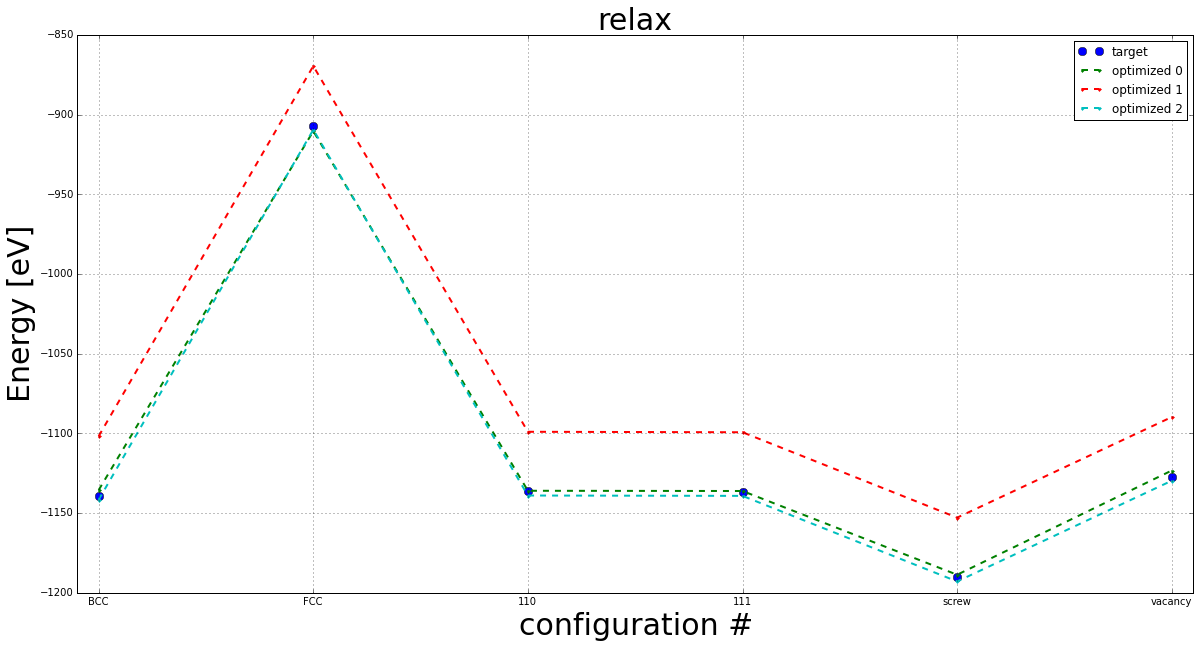

In [1416]:
# plot relax
x_ticks = ([0, 1, 2, 3, 4, 5], ['BCC', 'FCC','110','111', 'screw', 'vacancy'])
x_lim=(-0.1, 5.1)
slice_end = len(x_ticks[0])
select = slice(0, slice_end, None)
plot_udif(targets, stats, 'relax', optimal_params, select=select, x_ticks=x_ticks, x_lim=x_lim, shift=0)#-37)#-36)

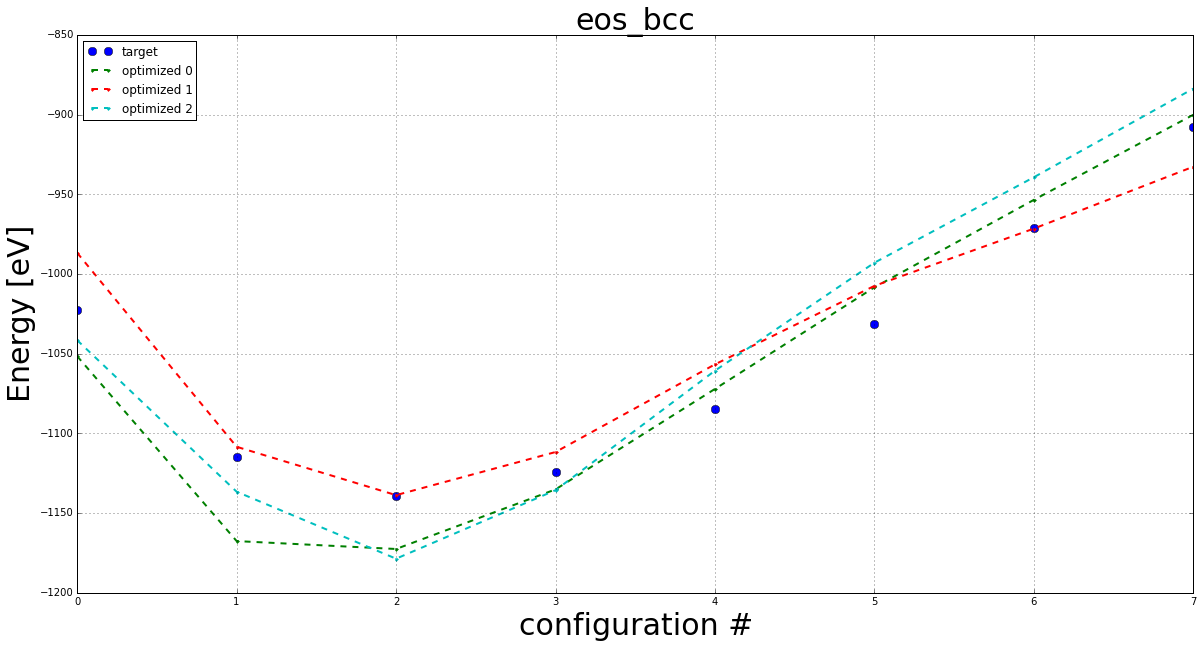

In [1417]:
# plot bcc EOS
select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
select = [1, 2, 0, 3, 4, 5, 6, 7]
x_lim = (2, 8)
y_lim = (-9.0, -7.0)
plot_udif(targets, stats, 'eos_bcc', optimal_params, shift=-37, select=select)#, x_lim=x_lim, y_lim=y_lim)

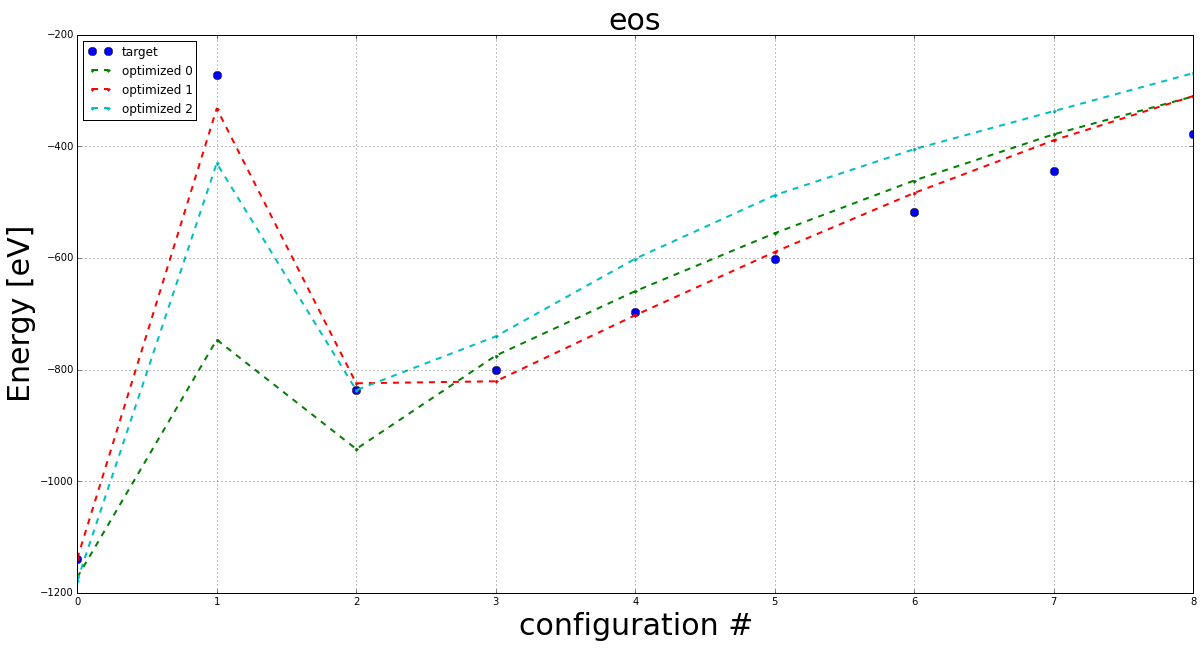

In [1418]:
#select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
#x_lim = (2, 8)
#y_lim = (-9.0, -7.0)
plot_udif(targets, stats, 'eos', optimal_params, shift=-37)#, select=select)#, x_lim=x_lim, y_lim=y_lim)

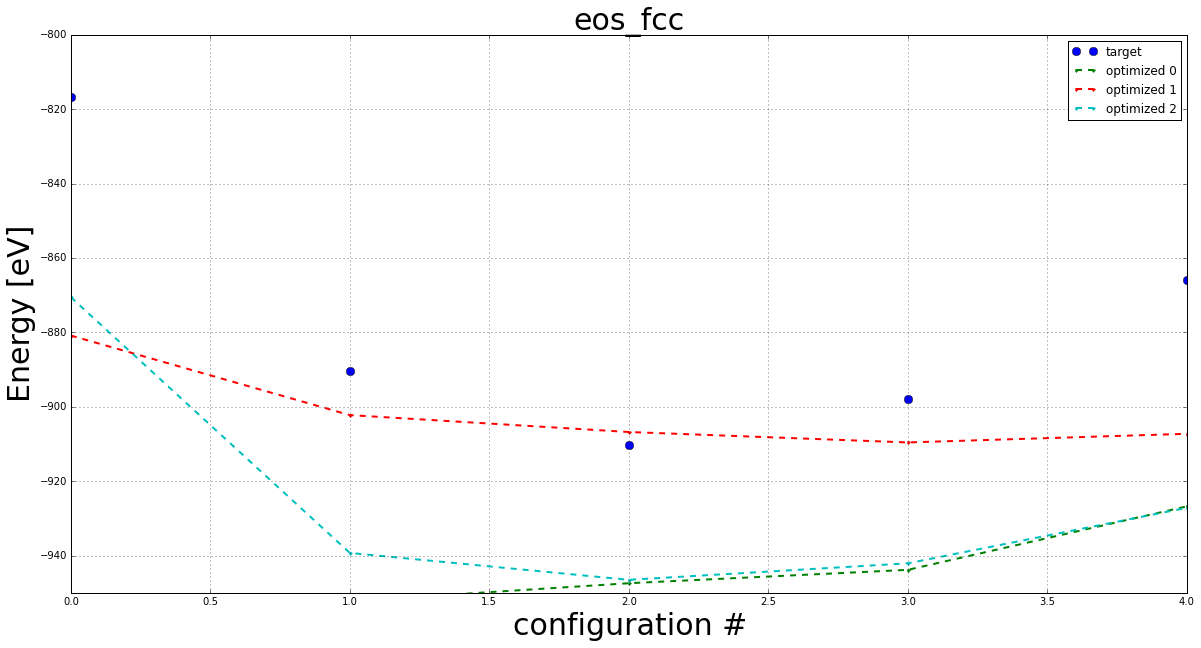

In [1419]:
# plot fcc EOS
#select = [1, 2, 3, 0, 5, 6, 7, 4]
select = [1, 2, 0, 3, 4]
x_lim = (0, 4)
y_lim = (-950, -800)
plot_udif(targets, stats, 'eos_fcc', optimal_params, x_lim=x_lim, y_lim=y_lim, select=select, shift=-37)#-36)#, select=select)


In [1420]:
targets['eos_fcc']['box']

[array([[ 12.11744292,   0.        ,   0.        ],
        [  0.        ,  12.11744292,   0.        ],
        [  0.        ,   0.        ,  12.11744292]]),
 array([[ 11.24883755,   0.        ,   0.        ],
        [  0.        ,  11.24883755,   0.        ],
        [  0.        ,   0.        ,  11.24883755]]),
 array([[ 11.69926251,   0.        ,   0.        ],
        [  0.        ,  11.69926251,   0.        ],
        [  0.        ,   0.        ,  11.69926251]]),
 array([[ 12.50859538,   0.        ,   0.        ],
        [  0.        ,  12.50859538,   0.        ],
        [  0.        ,   0.        ,  12.50859538]]),
 array([[ 12.87670456,   0.        ,   0.        ],
        [  0.        ,  12.87670456,   0.        ],
        [  0.        ,   0.        ,  12.87670456]])]

In [1421]:
# # plot MD trajectories
# x_lim = (2.8,8.2)
# y_lim = (-2250,-2100)
# #x_lim = (-0.2,2.2)
# #y_lim = (-3880,-3780)

# plot_udif(targets, stats, 'vacint', optimal_params, x_lim=x_lim, y_lim=y_lim)#, shift=-80)
# plot_udif(targets, stats, 'vacint', optimal_params, shift=-78, x_lim=x_lim, y_lim=y_lim)#, shift=-24.2)
#108/128.*37

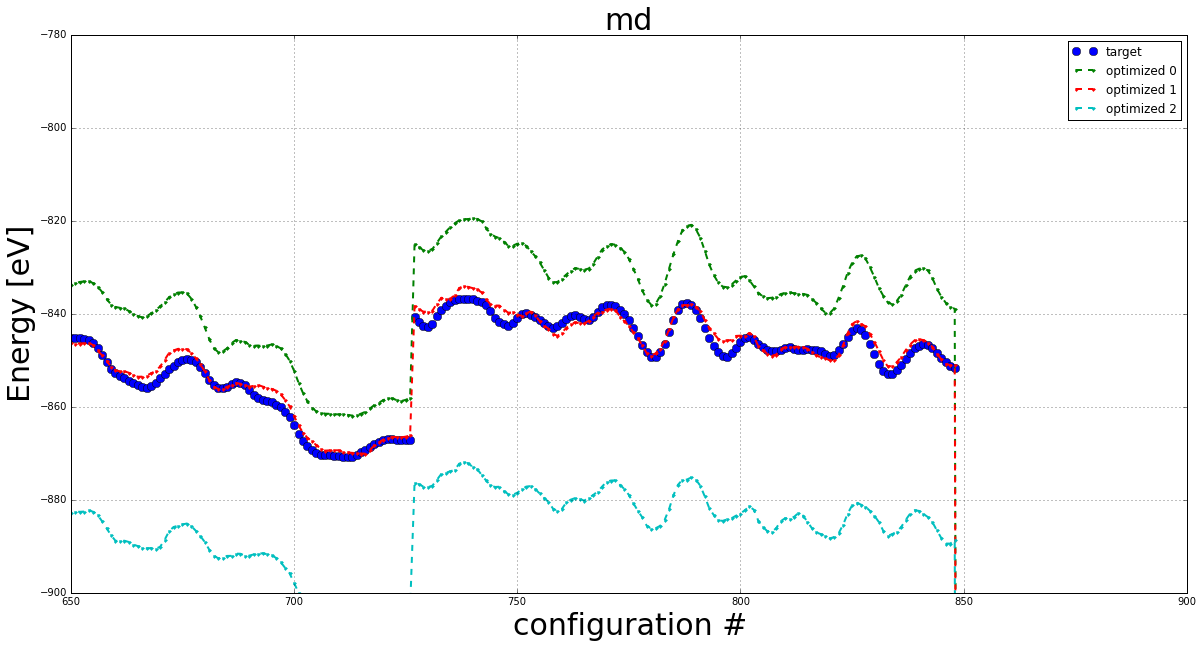

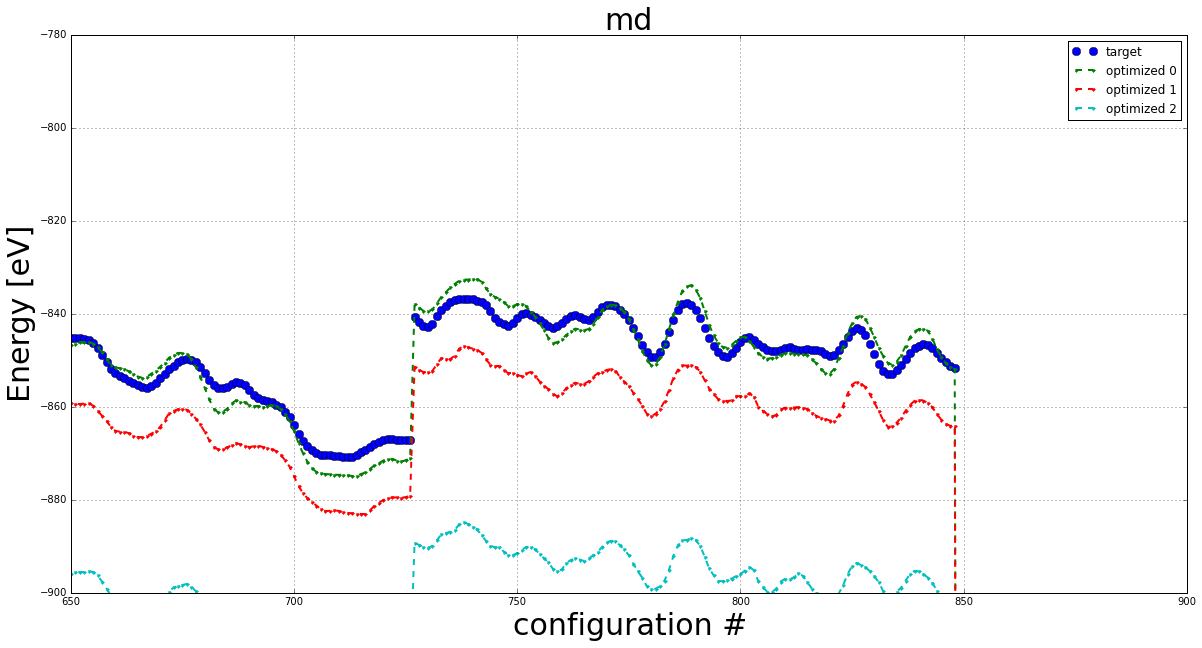

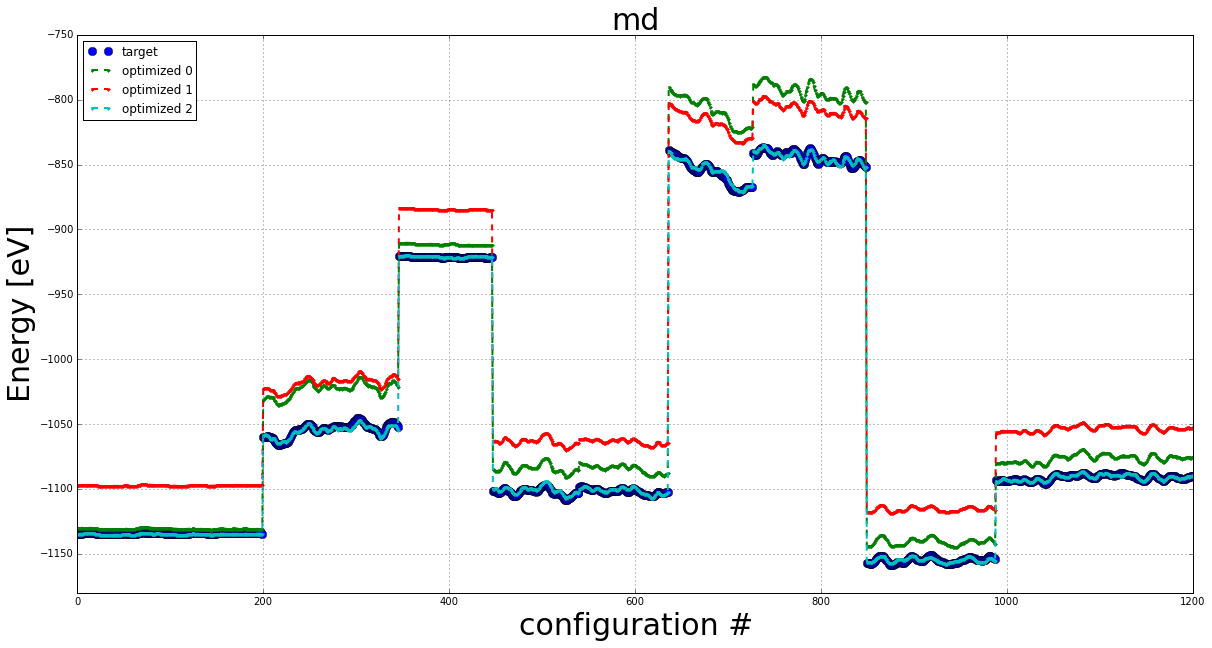

In [1422]:
# plot MD trajectories
x_lim = (350,520)
x_lim = (650, 900)
#x_lim = (350,450)
#x_lim = (0,200)
#x_lim = (930, 1020)
#x_lim = (200, 380)
#x_lim = (1120, 1200)
y_lim = (-900,-780)
#y_lim = (-1140,-1090)
#y_lim = (-940,-880)
#y_lim = (-880, -820)
#y_lim = (-925,-910)
#y_lim = (-1075, -1035)


plot_udif(targets, stats, 'md', optimal_params, x_lim=x_lim, y_lim=y_lim, shift=-37)
plot_udif(targets, stats, 'md', optimal_params, x_lim=x_lim, y_lim=y_lim, shift=-50)
x_lim = (0, 1200)
y_lim = (-1180, -750)
plot_udif(targets, stats, 'md', optimal_params[:], x_lim=x_lim, y_lim=y_lim, shift=0)
#plot_udif(targets, stats, 'md', optimal_params[:], x_lim=x_lim, y_lim=y_lim, shift=-40)

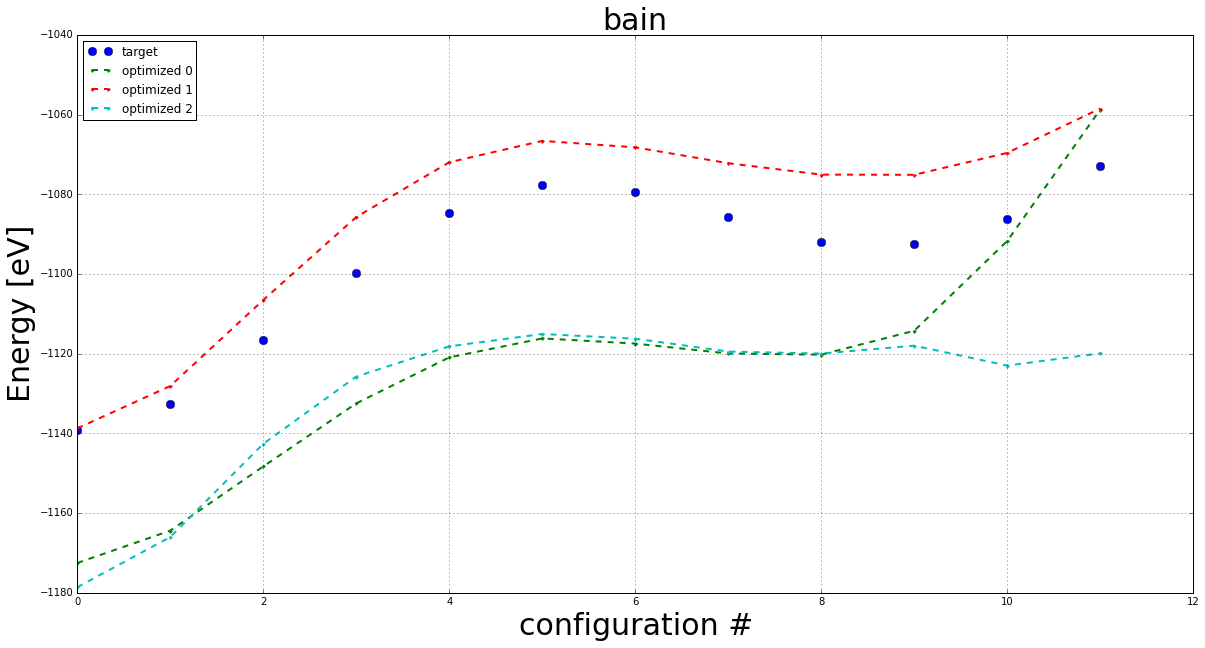

In [1423]:
# plot MD trajectories
x_lim = (380,420)
y_lim = (-900,-780)
plot_udif(targets, stats, 'bain', optimal_params, shift=-37)#, x_lim=x_lim, y_lim=y_lim)

In [1379]:
optimal_params

[(0.0, array([ -5.94645400e+00,  -4.94770000e-02,   0.00000000e+00,
           0.00000000e+00,   9.60851701e+01,  -1.84410924e+02,
           9.35784080e+01,  -7.98358265e+00,   7.47034093e+00,
          -1.52756044e+00,   1.25205933e+00,   1.63082162e+00,
          -1.41854775e+00,  -8.19936046e-01,   1.98013514e+00,
          -6.96430180e-01,   3.04546910e-02,  -1.63131143e+00,
           1.38409896e+00,  -4.20429108e+00,   0.00000000e+00,
           5.18217702e-01,   5.62720800e-02,   0.00000000e+00,
           3.44164179e-02,   0.00000000e+00])),
 (2.8099138621896525e-06,
  array([ -3.27882058e+00,  -9.77681860e-04,  -5.95486537e+02,
           3.42401535e+02,  -4.15497479e+02,   3.71316746e+02,
          -1.07274610e+02,  -2.93282898e+00,   1.51298572e+01,
          -1.37454674e+01,   8.16724633e+00,  -3.16850352e+00,
           8.74607042e-01,  -1.07878768e+00,   1.97939820e+00,
          -8.26149646e-01,  -1.62437297e-01,  -1.45694910e+00,
           1.42153527e+00,   1.29203135

In [1380]:
# select which parameters will be used for force field file
n_params = [2, 17, 7, 0]
optimal_list = []
for par in optimal_params:  
    optimal_list.append(to_param_dict(par[1], n_params))

In [1381]:
optimal_list

[{'params': {'edens': array([-4.20429108,  0.        ,  0.5182177 ,  0.05627208,  0.        ,
           0.03441642,  0.        ]),
   'embed': array([-5.946454, -0.049477]),
   'lrcorr': array([], dtype=float64),
   'pair': array([  0.00000000e+00,   0.00000000e+00,   9.60851701e+01,
           -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
            7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
            1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
            1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
           -1.63131143e+00,   1.38409896e+00])}},
 {'params': {'edens': array([  1.29203135e+02,  -9.25284676e+00,   2.63967417e+00,
            2.06410900e+00,   0.00000000e+00,   6.03258240e-02,
            5.85208452e-13]),
   'embed': array([ -3.27882058e+00,  -9.77681860e-04]),
   'lrcorr': array([], dtype=float64),
   'pair': array([ -5.95486537e+02,   3.42401535e+02,  -4.15497479e+02,
            3.71316746e+02,  -1.07274610e+02,  -2.93282898e+00,

In [1382]:
# Total pair potential
pos = targets['relax']['xyz'][0]
bx = targets['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [1383]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc and r > 0.01])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [1320]:
def eos_ene(ff_id):
    
    # spline knots
    V_x_r = stats['hyperparams']['pair']
    rho_x_r = stats['hyperparams']['edens']

    # parameters
    pair_y = optimal_list[ff_id]['params']['pair']
    many_y = optimal_list[ff_id]['params']['embed']
    rho_x_a = optimal_list[ff_id]['params']['edens']

    ene = []
    for a in np.linspace(0.5, 2.0, 101):
        z = a*rr
        u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

        u_many = 0.0
        for i in range(z.shape[0]):
            d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
            u_many += F(d, many_y)

        ene.append([a, u_pair, u_many, u_pair+u_many])

    return np.array(ene)

In [1321]:
ene_mye = eos_ene(2)
ene_my = eos_ene(1)
ene_mar = eos_ene(0)

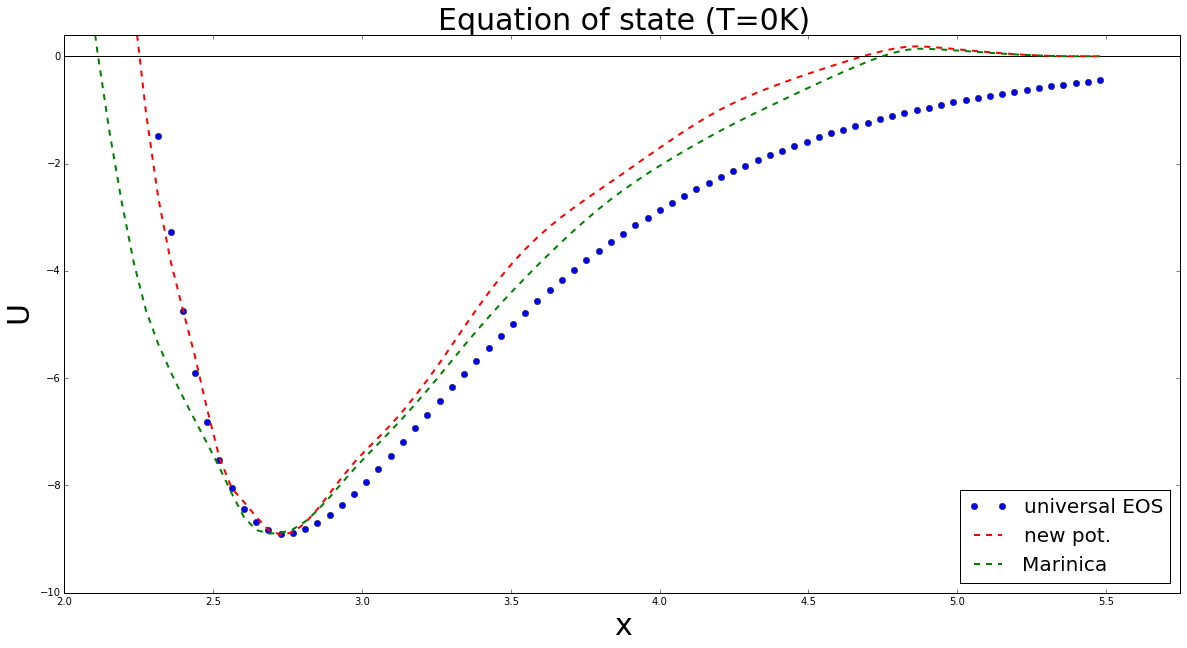

In [1385]:
plt.figure(figsize=(20,10))

plt.title('Equation of state (T=0K)', fontsize=30)

plt.plot(ene_my[:,0]*2.74, [universal_eos(x, 'W') for x in ene_my[:,0]], 'bo', label='universal EOS')
plt.plot(ene_mye[:,0]*2.74, ene_mye[:,3]/128,'--', lw=2, label='new pot.', color='r')
#plt.plot(ene_my[:,0]*2.74, ene_my[:,3]/128 - 0.28, label='u-my', color='r')
plt.plot(ene_mar[:,0]*2.74, ene_mar[:,3]/128,'--', lw=2, label='Marinica', color='g')
#plt.scatter(stats['hyperparams']['pair'], np.zeros(len(stats['hyperparams']['pair'])))
#plt.vlines(stats['hyperparams']['pair']+[2.22], -10, 0)
#plt.vlines(stats['hyperparams']['edens'], -10, 0, colors='m')

#plt.vlines(np.linspace(2.25, 5.5, 14), -10, 0, colors='r')
#plt.vlines([2.26, 2.5 , 2.66, 2.74, 2.86, 3.06, 3.30, 3.62 , 3.9, 4.22, 4.54, 4.86, 5.18, 5.5], -10, 0, colors='g')

plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend(loc='best', fontsize=20)
plt.xlim(2.0, 5.75)
#plt.xlim(2.6, 2.85)
plt.ylim(-10,0.4)
#plt.ylim(-9.,-8.5)

plt.xlabel('x', fontsize=30)
plt.ylabel(r'U', fontsize=30)
plt.savefig(os.path.join(reports, 'universal_eos'+'.png'))

In [1387]:
[(key, targets[key]['weight']) for key in targets]

[('bcc_npt_langevin_3700K', 1.0),
 ('md', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 1.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('eos_fcc', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('liq_5000K', 1.0),
 ('eos_bcc', 1.0),
 ('bain', 1.0)]

In [1389]:
ff_id = -1

# spline knots
pair_r = stats['hyperparams']['pair']
rho_r = stats['hyperparams']['edens']

# parameters
pair_a = optimal_list[ff_id]['params']['pair']
rho_a = optimal_list[ff_id]['params']['edens']
many_a = optimal_list[ff_id]['params']['embed']

In [1398]:
print(many_a)

[ -3.27882058e+00  -9.77681860e-04]


In [1393]:
# find electronic density maximum
rmax = max([(phi(r, rho_a, rho_r), r) for r in np.linspace(2.0, 4.9, 10000)])
rho_max, r_max = rmax
rho_max, r_max
rhomax = 12.0*phi(r_max, rho_a, rho_r)
rmax, rhomax

((22.085469153498732, 2.0), 265.02562984198477)

In [1394]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(r_max, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 10.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

('rhomax:', 265.02562984198477)


In [1395]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [1396]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) if x > r_max else rho_max for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [1397]:
# LAMMPS format

with open(os.path.join(pot_path, 'W_zeroenx.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    #fo.write(f"{n_el:5d} ")
    fo.write("{0:5d} ".format(n_el))

    for i in range(n_el):
        #fo.write(f"{el_name[i]:2}")
        fo.write("{0:2}".format(el_name[i]))
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    #fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    fo.write("{0:5d}{1:24.16e}{2:5d}{3:24.16e}{4:24.16e}\n".format(nrho, drho, nr, dr, rcut))

    # atomic number, mass, lattice size, lattice type
    #fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    fo.write("{0:5d} {1:14.4f} {2:14.4f} {3:10}\n".format(na, ma, lc, alat))

    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))

In [ ]:
# Yuri's format

with open(os.path.join(pot_path, 'W_pair.yuri'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    #fo.write(f"{n_el:5d} ")
    fo.write("{0:5d} ".format(n_el))

    for i in range(n_el):
        #fo.write(f"{el_name[i]:2}")
        fo.write("{0:2}".format(el_name[i]))
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    #fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    fo.write("{0:5d}{1:24.16e}{2:5d}{3:24.16e}{4:24.16e}\n".format(nrho, drho, nr, dr, rcut))

    # atomic number, mass, lattice size, lattice type
    #fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    fo.write("{0:5d} {1:14.4f} {2:14.4f} {3:10}\n".format(na, ma, lc, alat))

    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))